# 0.0. Planejamento
##  Input
### Dados: 
* **Id**: Identificador Único;
* **Title**: Título da vaga;
* **FullDescription**: Texto completo com a descrição da vaga;
* **LocationRaw**: Texto cru da localizacao da vaga;
* **LocationNormalized**: Localizacao normalizada - **Carrega erro**;
* **ContractType**: Tipo de contrato. Indica como é o regime de horas da vaga. Pode ser:
    * full_time;
    * part_time.
* **ContractTime**: Tempo de validade do contrato. Pode ser:
    * permanent;
    * contract.
* **Company**: Nome da compania que está contratanto;
* **Category**: 30 categorias de trabalho - **Carrega erro**;
* **SalaryNormalised**: Salario anualizado da vaga. O que estamos buscando prever;
* **SourceName**: Nome to site o qual recebemos a vaga.

### Problema:
* Temos um conjunto de dados com as informacoes de vagas abertas. Com base nessas \
informacoes, devemos criar um algoritmo capaz de prever o salário em novas vagas.

## Output
* **Modelo**: Um modelo capaz de prever o salario de novos usuarios;
* **WebApp**: Um webapp que carregue esse modelo e faça previsões;
* **EDA**: Uma Análise Exploratória dos Dados e do Modelo:
    - Relatório do Modelo;
    - Relatório do Projeto.


## Tasks
1. Planejamento;
2. Ciclos;
3. Construcao do Modelo Final;
    - Métrica Principal: Mean Absolute Error (MAE)
4. Desenvolvimento do WebApp;
5. Deploy;

# 1.0. Imports

In [46]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Plot
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import HTML

# Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from xgboost import XGBRegressor

## 1.1. Helper Functions

In [82]:
def jupyter_settings():
    """
    
    """
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()


def cross_val_performance(X_train, y_train, model, cv):
    
    # Cross Val Train
    results = cross_validate(model, 
                             X_train, 
                             y_train, 
                             cv=cv,
                             scoring=[
                                 'neg_mean_absolute_error', 
                                 'neg_mean_absolute_percentage_error', 
                                 'neg_root_mean_squared_error'
                             ]
                            )
    
    # Performance
    mae = round(np.mean(results['test_neg_mean_absolute_error'] * -1), 2)
    mape = round(np.mean(results['test_neg_mean_absolute_percentage_error'] * -1), 4)
    rmse = round(np.mean(results['test_neg_root_mean_squared_error'] * -1), 2)
    time = round(np.mean(results['fit_time']), 2)
    
    df_results = pd.DataFrame(
                {
                    'Modelo': type(model).__name__,
                    'MAE': mae,
                    'MAPE': mape,
                    'RMSE': rmse,
                    'time': time
                },
                index=[0]
            )
    
    return df_results


def baseline_performance(y_train, n_splits):
    """
    Return a cross validation metric from the baseline model - mean
    Input:
        y_train: array with train response variables
        n_splits: number of folds
    """
    kf = KFold(n_splits=n_splits)
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for train_index, valid_index in kf.split(y_train): # split index train - valid
        
        new_y_train = y_train.iloc[train_index]
        new_y_valid = y_train.iloc[valid_index]
        
        y_hat = np.repeat(new_y_train.mean(), len(new_y_valid))
        
        mae_list.append(mean_absolute_error(new_y_valid, y_hat))
        mape_list.append(mean_absolute_percentage_error(new_y_valid, y_hat))
        rmse_list.append(sqrt(mean_squared_error(new_y_valid, y_hat)))
        
    df_results = pd.DataFrame(
                {
                    'Modelo': 'Baseline',
                    'MAE': round(np.mean(mae_list), 3),
                    'MAPE': round(np.mean(mape_list), 3),
                    'RMSE': round(np.mean(rmse_list), 3),
                    'time': 0
                },
                index=[0]
            )
    
    return df_results

Populating the interactive namespace from numpy and matplotlib


## 1.2. Data

In [4]:
data_import = pd.read_csv('../data/Train_rev1.csv')

data_import.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


# 2.0. Data Description

In [5]:
df2 = data_import.copy()

## 2.1. Shape Data

In [6]:
print(f'Rows: {df2.shape[0]}')
print(f'Columns: {df2.shape[1]}')

Rows: 244768
Columns: 12


## 2.2. Data Types

In [7]:
df2.dtypes

Id                     int64
Title                 object
FullDescription       object
LocationRaw           object
LocationNormalized    object
ContractType          object
ContractTime          object
Company               object
Category              object
SalaryRaw             object
SalaryNormalized       int64
SourceName            object
dtype: object

## 2.3. Check Na


In [8]:
tot_na = df2.isnull().sum()
percentage_na = round(df2.isnull().mean(), 4) * 100

# dataframe of na
pd.DataFrame([tot_na, percentage_na], index=['Total', 'Percentual']).T

,Total,Percentual
Id,0.0,0.00
Title,1.0,0.00
FullDescription,0.0,0.00
LocationRaw,0.0,0.00
LocationNormalized,0.0,0.00
ContractType,179326.0,73.26
ContractTime,63905.0,26.11
Company,32430.0,13.25
Category,0.0,0.00
SalaryRaw,0.0,0.00


## 2.4. Pre-Analysis

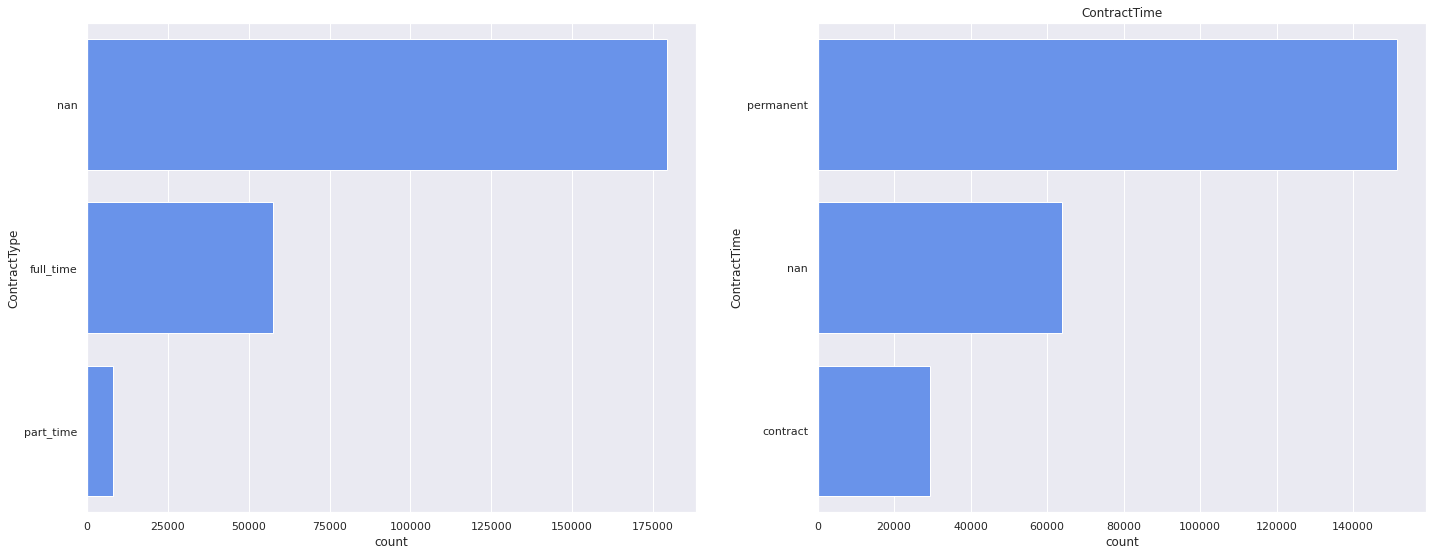

In [9]:
# Plotando colunas com poucos valores
columns = ['ContractType', 'ContractTime']

fig, ax = plt.subplots(1, 2)

for i, val in enumerate(columns):
    sns.countplot(y = df2[val].astype('str'), color='#548CFF', ax=ax[i])
    plt.title(val)

# 3.0. Variable Filtering

In [10]:
df3 = df2.copy()

In [11]:
df3.drop(['Id', 'LocationRaw', 'SalaryRaw', 'Title', 'FullDescription', 'SourceName', 'Company', 'LocationNormalized'], axis=1, inplace=True)

# 4.0. Feature Engineering

In [12]:
df4 = df3.copy()

# 5.0. Exploratory Data Analysis

In [13]:
df5 = df4.copy()

# 6.0. Data Preparation

In [14]:
X = df5.drop('SalaryNormalized', axis=1)
y = df5['SalaryNormalized']

## 6.1. NA Values

## 6.1. Train Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.2. Na Values

In [16]:
X_train.isnull().sum()

ContractType    143245
ContractTime     51332
Category             0
dtype: int64

In [17]:
X_train.loc[X_train['ContractType'].isnull(), 'ContractType'] = 'null'
X_train.loc[X_train['ContractTime'].isnull(), 'ContractTime'] = 'null'

In [18]:
X_test.loc[X_test['ContractType'].isnull(), 'ContractType'] = 'null'
X_test.loc[X_test['ContractTime'].isnull(), 'ContractTime'] = 'null'

## 6.3. Categorical

### 6.3.1. One Hot Encoder

In [19]:
trf2 = ColumnTransformer(transformers =[
    ('enc', OneHotEncoder(sparse = False, drop ='first'), list(range(3))),
], remainder ='passthrough')

In [20]:
X_train = pd.DataFrame(trf2.fit_transform(X_train))
X_test = pd.DataFrame(trf2.fit_transform(X_test))

# 7.0. Feature Selection

# 8.0. Machine Learning Pipeline

Neste Ciclo 1, o modelo que melhor performou foi a DecisionTreeRegressor

## 8.1. Baseline - Mean

In [66]:
base = baseline_performance(y_train, 5)

## 8.2. Linear Regression

In [67]:
lr = LinearRegression()

lr_model = cross_val_performance(X_train, y_train, cv=5, model=lr)

## 8.3. DecisionTreeRegressor

In [68]:
dtr = DecisionTreeRegressor()

dtr_model = cross_val_performance(X_train, y_train, cv=5, model=dtr)

## 8.4. RandomForestRegressor

In [69]:
rf = RandomForestRegressor(n_jobs=-1)

rf_model = cross_val_performance(X_train, y_train, cv=5, model=rf)

## 8.5. XGBRegressor

In [70]:
xgb = XGBRegressor(n_jobs=-1)

xgb_model = cross_val_performance(X_train, y_train, cv=5, model=xgb)

## 8.6. Comparance

In [84]:
cross_performance = pd.concat([base, lr_model, dtr_model, rf_model, xgb_model]).sort_values(by='MAE').reset_index(drop=True)

cross_performance

,Modelo,MAE,MAPE,RMSE,time
0,DecisionTreeRegressor,11123.910,0.3857,15360.100,0.80
1,RandomForestRegressor,11124.340,0.3857,15360.060,33.64
2,XGBRegressor,11148.600,0.3868,15382.060,15.74
3,LinearRegression,11970.390,0.4198,16153.800,0.44
4,Baseline,13402.185,0.4940,17641.151,0.00


In [86]:
# save performance
# cross_performance.to_csv('../data/cross_performance_c00.csv')

# 9.0. Performance - Test Data

In [31]:
dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)

y_hat = dtr.predict(X_test)

In [32]:
mean_absolute_error(y_test, y_hat)

11113.402243996165

# 10.0. Deploy